In [56]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from pyomo.environ import *
from optimization_utils_old import *
from param_loader import METANET_Params
from simulation_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
# rho_hat = df["Density"]
# q_hat = df["Flow"]
# print(max(q_hat))
# C_i = np.mean(sorted(q_hat)[-5:])
# print("C_i", C_i)
# K = len(rho_hat)

RESULTS_DIR = "calibration_results"

q_hat = np.load("data/flow_10sec_400m_1hr.npy")
print(np.max(q_hat))
rho_hat = np.load("data/density_10sec_400m_1hr.npy")
v_hat = q_hat / rho_hat
print(rho_hat.shape)
flattened_q_hat = q_hat.flatten()
print(max(flattened_q_hat))
flattened_rho_hat = rho_hat.flatten()
C_i = np.mean(np.sort(flattened_q_hat)[-5:])
print("C_i", C_i)
K = len(flattened_rho_hat)
print("K", K)

6773.200199999966
(360, 16)
6773.200199999966
C_i 6718.716719999977
K 5760


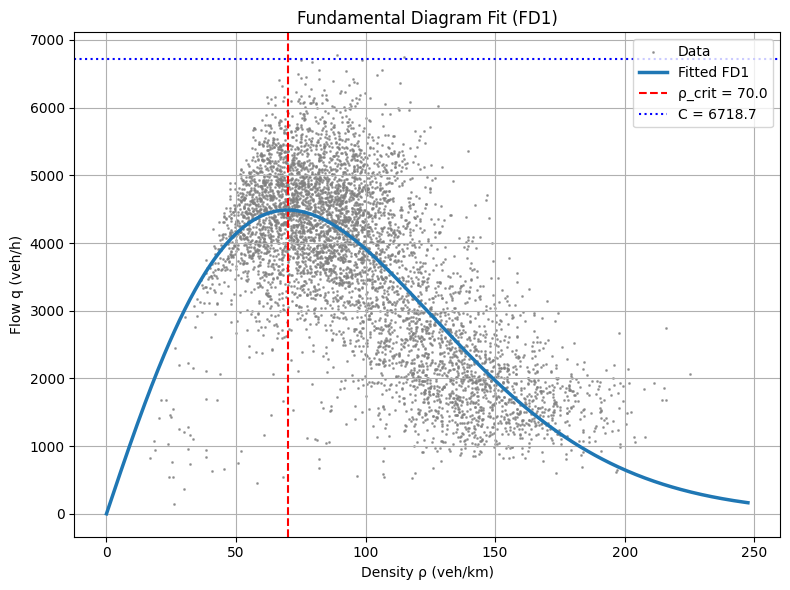

{'rho_crit': 69.95774856112287, 'V_free': 114.25733457721735, 'a': 1.7319895914943968, 'C': np.float64(6718.716719999977), 'Q_fd1': <function fit_fd1.<locals>.Q_fd1 at 0x142c10f60>}


In [58]:
params = fit_fd1(flattened_rho_hat, flattened_q_hat)
print(params)

In [59]:
rho_hat = np.where(rho_hat == 0.0, 1e-3, rho_hat)
q_hat = np.where(q_hat == 0.0, 1e-3, q_hat)
# v_hat = q_hat / rho_hat
# v_hat = np.where(v_hat == 0.0, 1e-3, v_hat)

In [ ]:
random.seed(1)

T = 10 / 3600
l = 0.4
num_calibrated_segments = 14
include_ramping = False
varylanes = False
# lane_mapping = np.array([4 if i < num_calibrated_segments - 4 else 2 for i in range(num_calibrated_segments)])

results = run_calibration(
    rho_hat,
    q_hat,
    T,
    l,
    num_calibrated_segments=num_calibrated_segments,
    varylanes=varylanes,
    include_ramping=include_ramping,
    smoothing=True
)

1 15
360 14
(360, 1)
(360, 1)


In [42]:
# Save initial and downstream conditions
np.save(f"{RESULTS_DIR}/upstream_flow.npy", q_hat[:, 0])
np.save(f"{RESULTS_DIR}/downstream_density.npy", rho_hat[:, -1])

In [43]:
tau_array = results["tau"]
K_array = results["K"]
eta_high_array = results["eta_high"]
rho_crit_array = results["rho_crit"]
v_free_array = results["v_free"]
a_array = results["a"]
num_lanes_array = results["num_lanes"]
if include_ramping:
    # gamma_array = results["gamma"]
    beta_array = results["beta"]
    r_inflow_array = results["r_inflow"]

In [44]:
# r_array = np.zeros(num_calibrated_segments)
# beta_array = np.zeros(num_calibrated_segments)
# print(beta_array.shape)
# print(r_inflow_array.shape)

In [45]:
# Save everything
v_pred_array = results["v_pred"]
rho_pred_array = results["rho_pred"]
q_array = v_pred_array * rho_pred_array
np.save(f"{RESULTS_DIR}/tau.npy", tau_array)
np.save(f"{RESULTS_DIR}/K.npy", K_array)
np.save(f"{RESULTS_DIR}/eta_high.npy", eta_high_array)
np.save(f"{RESULTS_DIR}/rho_crit.npy", rho_crit_array)
np.save(f"{RESULTS_DIR}/v_free.npy", v_free_array)
np.save(f"{RESULTS_DIR}/a.npy", a_array)
np.save(f"{RESULTS_DIR}/num_lanes.npy", num_lanes_array)
np.save(f"{RESULTS_DIR}/q_pred.npy", q_array)
np.save(f"{RESULTS_DIR}/v_pred.npy", v_pred_array)
np.save(f"{RESULTS_DIR}/rho_pred.npy", rho_pred_array)
# np.save("r_array.npy", r_array)
if include_ramping:
    # np.save("gamma_array.npy", gamma_array)
    np.save(f"{RESULTS_DIR}/beta_array.npy", beta_array)
    np.save(f"{RESULTS_DIR}/r_inflow_array.npy", r_inflow_array)

(360, 14)


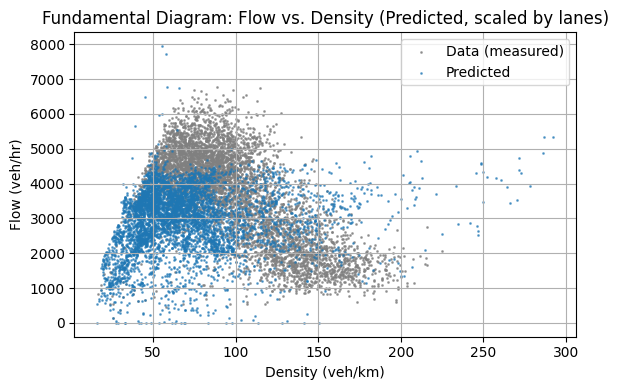

In [46]:
import matplotlib.pyplot as plt

# # Collect scaled predictions across all segments
all_rho_pred = rho_pred_array

print(all_rho_pred.shape)
all_v_pred = v_pred_array
all_q_pred = all_rho_pred * all_v_pred


# Stack predictions
all_rho_pred = np.hstack(all_rho_pred)
all_q_pred = np.hstack(all_q_pred)
all_v_pred = np.hstack(all_v_pred)

assert np.all(v_pred_array[0,:] == v_hat[0,1:-1])
assert np.all(v_pred_array[0,:] == v_hat[0,1:-1])
# Plot
plt.figure(figsize=(6, 4))
plt.scatter(rho_hat, q_hat, color="gray", alpha=0.7, s=1, label="Data (measured)")
plt.scatter(all_rho_pred, all_q_pred, alpha=0.6, s=1, label="Predicted")
plt.xlabel("Density (veh/km)")
plt.ylabel("Flow (veh/hr)")
plt.title("Fundamental Diagram: Flow vs. Density (Predicted, scaled by lanes)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

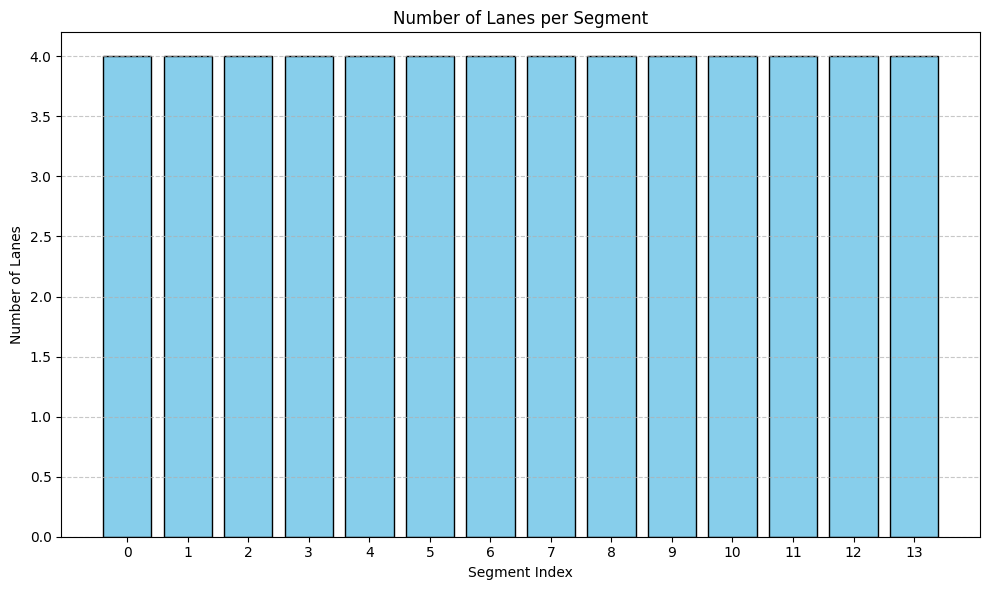

In [48]:
plt.figure(figsize=(10, 6))
plt.bar(
    np.arange(len(num_lanes_array)), num_lanes_array, color="skyblue", edgecolor="black"
)

plt.xlabel("Segment Index")
plt.ylabel("Number of Lanes")
plt.title("Number of Lanes per Segment")
plt.xticks(np.arange(len(num_lanes_array)))  # show all indices
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()

In [49]:
if include_ramping:
    plt.figure(figsize=(10, 6))
    plt.bar(
        np.arange(len(r_inflow_array)), r_inflow_array, color="skyblue", edgecolor="black"
    )

    plt.xlabel("Segment Index")
    plt.ylabel("Inflow")
    plt.title("Inflow per Segment")
    plt.xticks(np.arange(len(num_lanes_array)))  # show all indices
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()

In [50]:
if include_ramping:
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(len(beta_array)), beta_array, color="skyblue", edgecolor="black")

    plt.xlabel("Segment Index")
    plt.ylabel("Inflow")
    plt.title("Beta per Segment")
    plt.xticks(np.arange(len(num_lanes_array)))  # show all indices
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()

In [51]:
print(all_v_pred.shape)
q_array = rho_pred_array * v_pred_array
print("rho mape", mape(rho_hat[:, 1:-1], rho_pred_array))
print("q mape", mape(q_hat[:, 1:-1], q_array))
print("v mape", mape(v_hat[:, 1:-1], v_pred_array))
print("----------------")
print("rho rmse", rmse(rho_hat[:, 1:-1], rho_pred_array))
print("q rmse", rmse(q_hat[:, 1:-1], q_array))
print("v rmse", rmse(v_hat[:, 1:-1], v_pred_array))

(5040,)
rho mape 38.33402840476808
q mape 38.64911421584852
v mape 74.28311030348684
----------------
rho rmse 50.33065085383522
q rmse 1487.5605856160541
v rmse 23.58869008223019


In [ ]:
print("Simulating with calibrated parameters...")

# Scale densities per lane for simulation
scaled_rho_hat = rho_hat[:, 1:-1] / np.array(num_lanes_array)


# if smoothing boundary conditions
downstream_density = smooth_inflow(rho_hat[:, -1]) / num_lanes_array[-1]
data_inflow = smooth_inflow(q_hat[:, 0])
# downstream_density = rho_hat[:, -1] / num_lanes_array[-1]
# data_inflow = q_hat[:, 0]
# print(downstream_density[250:270])
# print(rho_hat[250:270, -1])

print(np.where(scaled_rho_hat < 0))
# Sim requires tuple of initial conditions: density, velocity, inflow, and queue
init_traffic_state = (scaled_rho_hat[0, :], v_hat[0, 1:-1], data_inflow[0], 0)
params = METANET_Params(path=RESULTS_DIR, num_segments=num_calibrated_segments).get_params()
rho_sim, v_sim, _, tts_sim = run_metanet_sim(
    T, 
    l, 
    init_traffic_state,
    data_inflow,
    downstream_density,
    params,
    vsl_speeds=None,
    lanes={i: num_lanes_array[i] for i in range(num_calibrated_segments)},
    plotting=True,
    real_data=True
)

print(rho_pred_array[230:270, -1])
print(rho_sim[230:270, -1] * 4)

Simulating with calibrated parameters...
(array([], dtype=int64), array([], dtype=int64))
360 14
[ 60.94454682  61.20078591  62.04098088  62.59478176  62.10571643
  62.56609316  64.55406864  64.7016866   63.71828464  65.99491717
  68.77478844  65.59232318  65.68419737  71.21158088  70.36765427
  66.25722306  65.76811162  69.37537354  79.06043127  95.13541645
 105.35898254 111.88685112 120.95891166 133.15956264 143.00784726
 148.48114788 150.67427402 147.9878228  139.9901472  123.08498795
 103.23481027 100.44323387 106.50696672  95.57256969  89.21390973
  89.82483483  87.00136137  84.10292119  83.26230318  81.27454909]
[ 34.59897025  33.32267097  33.00540044  33.40451856  34.76191617
  36.26791621  36.22669339  35.20608145  34.4778085   34.48301713
  36.32384854  38.30252166  39.65989763  40.4483573   42.54237319
  45.8589446   51.30876935  57.80851827  62.94822481  68.14110249
  73.47121324  82.39915417  96.0733429  108.66197245 117.44160734
 124.2503992  130.45515674 135.84137486 140.

Pred shape: (360, 14)
True shape: (360, 14)
Max true density: 225.06999625000026


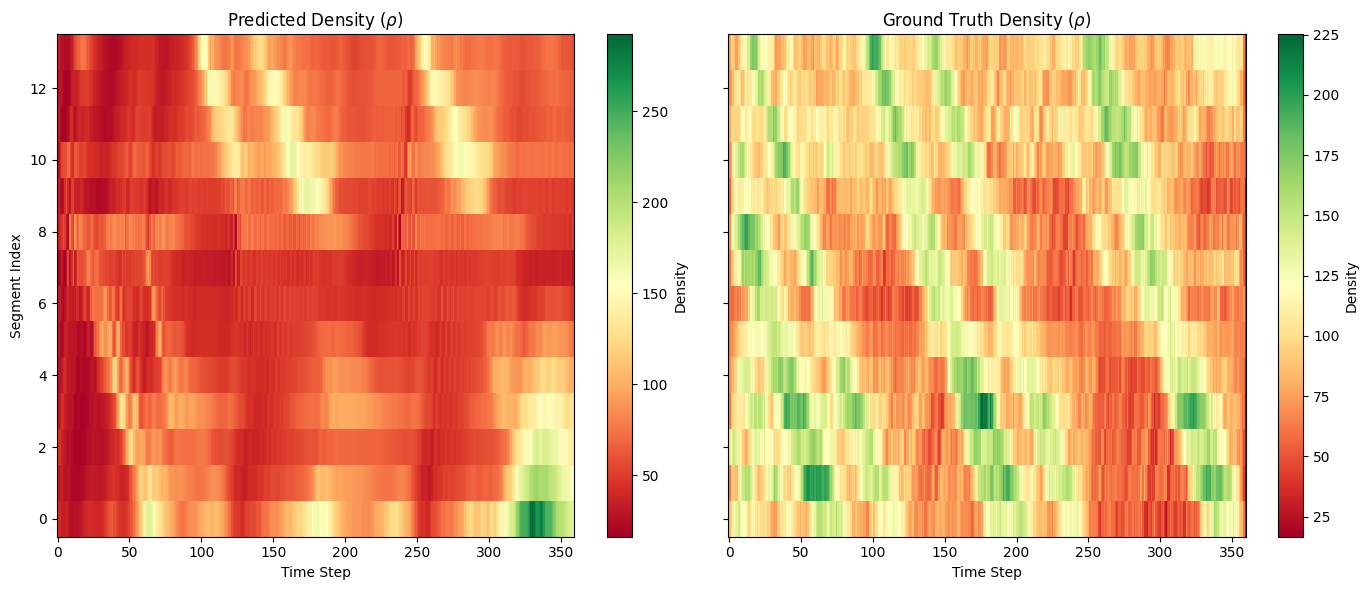

In [53]:
rho_plot_pred = rho_pred_array
rho_plot_true = rho_hat[:, 1:-1]

print("Pred shape:", rho_plot_pred.shape)
print("True shape:", rho_plot_true.shape)
print("Max true density:", np.max(rho_plot_true))

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Prediction ---
im0 = axes[0].imshow(
    rho_plot_pred.T, aspect="auto", origin="lower", cmap="RdYlGn", interpolation="none"
)
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("Segment Index")
axes[0].set_title("Predicted Density ($\\rho$)")
fig.colorbar(im0, ax=axes[0], label="Density")

# --- Ground Truth ---
im1 = axes[1].imshow(
    rho_plot_true.T, aspect="auto", origin="lower", cmap="RdYlGn", interpolation="none"
)
axes[1].set_xlabel("Time Step")
axes[1].set_title("Ground Truth Density ($\\rho$)")
fig.colorbar(im1, ax=axes[1], label="Density")

plt.tight_layout()
plt.show()

[15.60562109 22.63969379 14.53123911 33.0528382  44.74894381 40.31822336
 36.43426698 50.4408325  24.55019846 12.00645115  5.34702448 21.88636564
 40.55200066 44.41112619]
[48.82682541 52.93692393 45.16274615 42.58582922 48.08132988 76.2681249
 67.0266343  63.75195738 26.57700545 59.48456436  2.19148125 35.82471111
 39.9017026  60.39299666]
Pred shape: (360, 14)
True shape: (360, 14)
Max true density: 102.5494591064967


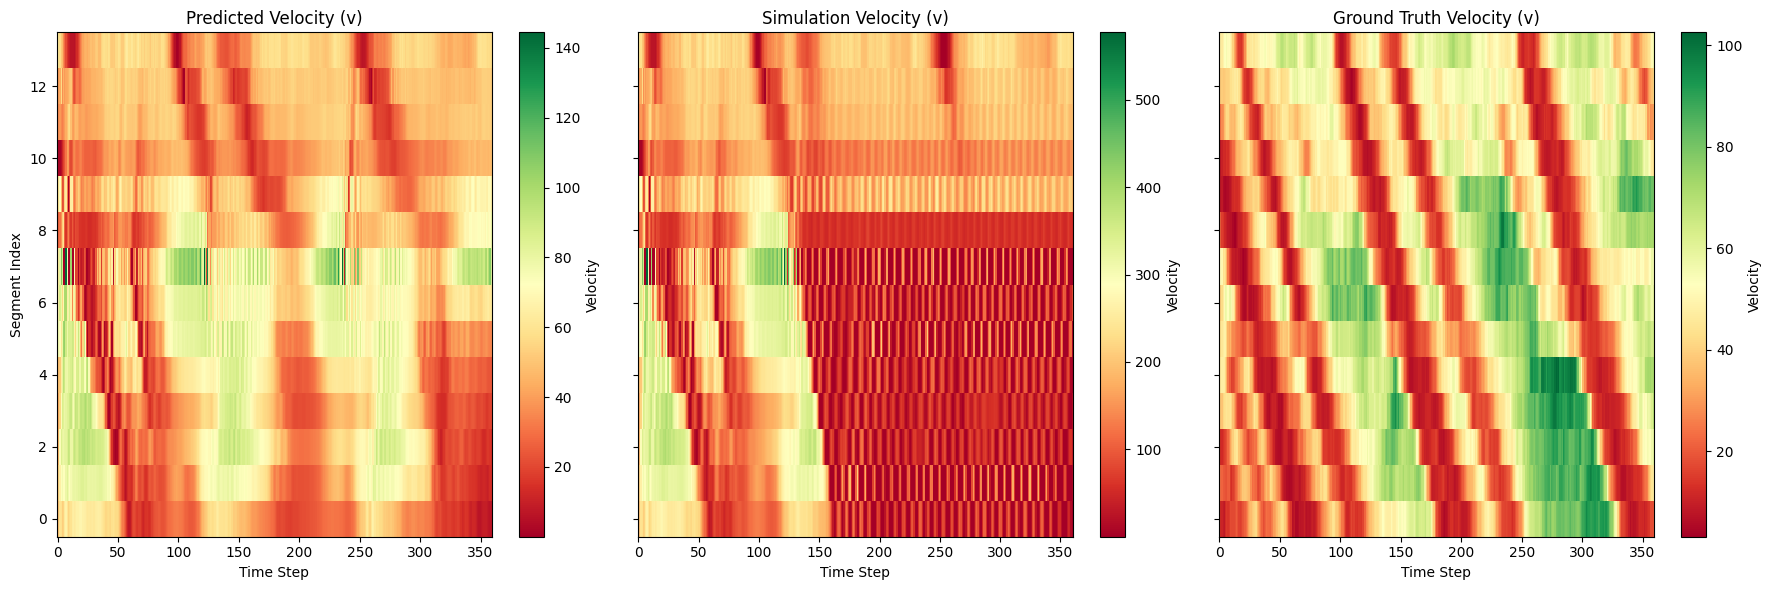

In [54]:
print(v_pred_array[0, :])
print(v_pred_array[1, :])
v_plot_pred = v_pred_array
v_plot_true = v_hat[:, 1:-1]

print("Pred shape:", v_plot_pred.shape)
print("True shape:", v_plot_true.shape)
print("Max true density:", np.max(v_plot_true))

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# --- Prediction ---
im0 = axes[0].imshow(
    v_plot_pred.T, aspect="auto", origin="lower", cmap="RdYlGn", interpolation="none"
)
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("Segment Index")
axes[0].set_title("Predicted Velocity (v)")
fig.colorbar(im0, ax=axes[0], label="Velocity")

# --- Simulation ---
im1 = axes[1].imshow(
    v_sim.T * 4, aspect="auto", origin="lower", cmap="RdYlGn", interpolation="none"
)
axes[1].set_xlabel("Time Step")
axes[1].set_title("Simulation Velocity (v)")
fig.colorbar(im1, ax=axes[1], label="Velocity")


# --- Ground Truth ---
im2 = axes[2].imshow(
    v_plot_true.T, aspect="auto", origin="lower", cmap="RdYlGn", interpolation="none"
)
axes[2].set_xlabel("Time Step")
axes[2].set_title("Ground Truth Velocity (v)")
fig.colorbar(im2, ax=axes[2], label="Velocity")

plt.tight_layout()
plt.show()

In [55]:
print(downstream_density[250:270])
print(rho_hat[250:270, -1]/num_lanes_array[-1])

[34.98249912 33.95999906 33.08749856 33.63249875 31.94249887 30.87999925
 29.44749944 25.04499944 25.10999887 21.2074995  19.4599995  16.24249913
 19.29999869 20.11249894 18.76499894 18.46749925 19.727499   17.88499875
 20.15749913 19.87999919]
[34.98249912 33.95999906 33.08749856 33.63249875 31.94249887 30.87999925
 29.44749944 25.04499944 25.10999887 21.2074995  19.4599995  16.24249913
 19.29999869 20.11249894 18.76499894 18.46749925 19.727499   17.88499875
 20.15749913 19.87999919]


/var/folders/kl/txwf6c7d73v3xczbyqm3trhw0000gn/T/ipykernel_18604/69037064.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


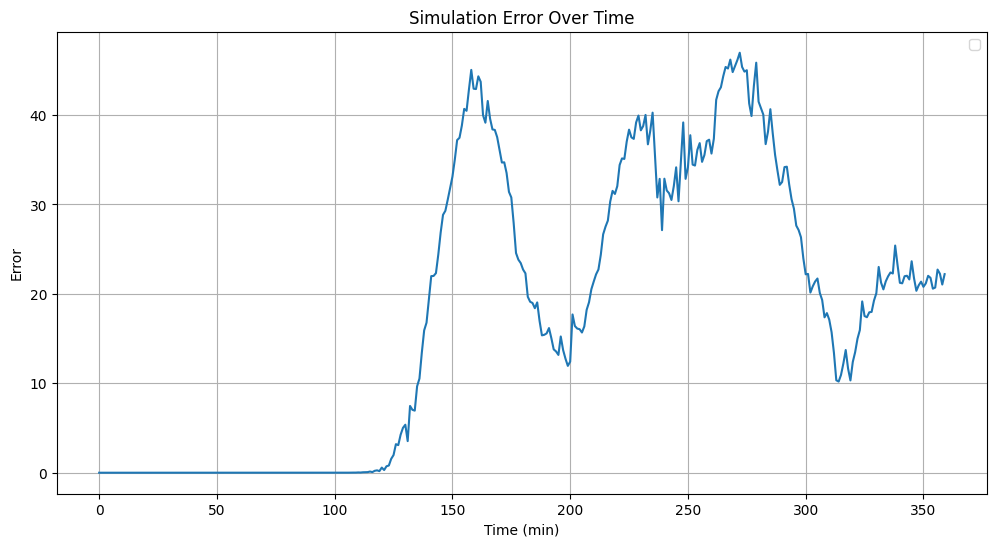

In [41]:
# plot error over time between prediction and simulation
plt.figure(figsize=(12, 6))
plt.plot(np.abs(v_plot_pred - v_sim[0:-1, :]).mean(axis=1))
plt.xlabel('Time (min)')
plt.ylabel('Error')
plt.title('Simulation Error Over Time')
plt.legend()
plt.grid()
plt.show()

In [ ]:
rho_plot_pred = rho_pred_array * v_pred_array
rho_plot_true = q_hat[:, 1:-1]

print("Pred shape:", rho_plot_pred.shape)
print("True shape:", rho_plot_true.shape)
print("Max true density:", np.max(rho_plot_true))

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Prediction ---
im0 = axes[0].imshow(
    rho_plot_pred.T, aspect="auto", origin="lower", cmap="RdYlGn", interpolation="none"
)
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("Segment Index")
axes[0].set_title("Predicted Flow ($\\rho$)")
fig.colorbar(im0, ax=axes[0], label="Flow")

# --- Ground Truth ---
im1 = axes[1].imshow(
    rho_plot_true.T, aspect="auto", origin="lower", cmap="RdYlGn", interpolation="none"
)
axes[1].set_xlabel("Time Step")
axes[1].set_title("Ground Truth Flow ($\\rho$)")
fig.colorbar(im1, ax=axes[1], label="Flow")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def smooth_inflow(inflow, window_size=2):
    kernel = np.ones(window_size) / window_size
    smoothed = np.apply_along_axis(
        lambda m: np.convolve(m, kernel, mode="same"), axis=0, arr=inflow
    )
    return smoothed


# Example input arrays (replace with your real q_hat and rho_hat)
# timesteps = 100
# q_hat = np.random.uniform(500, 1000, size=(timesteps, 5))   # flow [veh/h]
# rho_hat = np.random.uniform(10, 50, size=(timesteps, 5))    # density [veh/km]

# Apply smoothing
initial_flow = smooth_inflow(q_hat[:, 0:1])  # upstream inflow
downstream_density = smooth_inflow(rho_hat[:, -1:])  # downstream density

# Plotting
plt.figure(figsize=(12, 5))

# Flow vs timesteps
plt.subplot(1, 2, 1)
plt.plot(initial_flow, label="Initial Flow (smoothed)")
plt.xlabel("Timestep")
plt.ylabel("Flow [veh/h]")
plt.title("Upstream Inflow vs Timesteps")
plt.legend()

# Density vs timesteps
plt.subplot(1, 2, 2)
plt.plot(downstream_density, color="orange", label="Downstream Density (smoothed)")
plt.xlabel("Timestep")
plt.ylabel("Density [veh/km]")
plt.title("Downstream Density vs Timesteps")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def get_velocity_heatmap(v_hat, v_pred, q_hat, q_pred, rho_hat, rho_pred):
    shortened_v_hat = v_hat[:, 1:-1]
    shortened_rho_hat = rho_hat[:, 1:-1]
    shortened_q_hat = q_hat[:, 1:-1]
    # Determine some set of 3 scalars for each of q, rho, v to make a unified map
    v_diff = (shortened_v_hat - v_pred) / np.max(shortened_v_hat)
    rho_diff = (shortened_rho_hat - rho_pred) / np.max(shortened_rho_hat)
    q_diff = (shortened_q_hat - q_pred) / np.max(shortened_q_hat)

    diff = v_diff + rho_diff + q_diff
    fig, ax = plt.subplots(figsize=(14, 6))

    im = ax.imshow(
        diff.T,
        aspect="auto",
        origin="lower",
        cmap="viridis",
        interpolation="none",
        vmin=0,
    )
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Segment Index")
    ax.set_title("Absolute Inflow Difference |Pred - True|")
    fig.colorbar(im, ax=ax, label="|Flow Difference|")
    plt.show()


get_velocity_heatmap(v_hat, v_pred_array, q_hat, q_array, rho_hat, rho_pred_array)